## Inicialización

In [1]:
import pandas as pd
import numpy as np
import scipy
import sys
sys.modules['scipy'] = scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
path = "C:/Users/david/1.Archivos-Directorios/Python/datasets/faces/"
images_dir = path + "final_files"
df = pd.read_csv(path + "labels.csv")

## EDA

In [3]:
print(df.head())
print(df.info())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [4]:
#Revisión de distribución de edad
print(df["real_age"].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


Se seleccionaron 16 imágenes para mostrar.
Error abriendo imagen: C:/Users/david/1.Archivos-Directorios/Python/datasets/faces/final_files/000779.jpg -> num must be an integer with 1 <= num <= 15, not 16


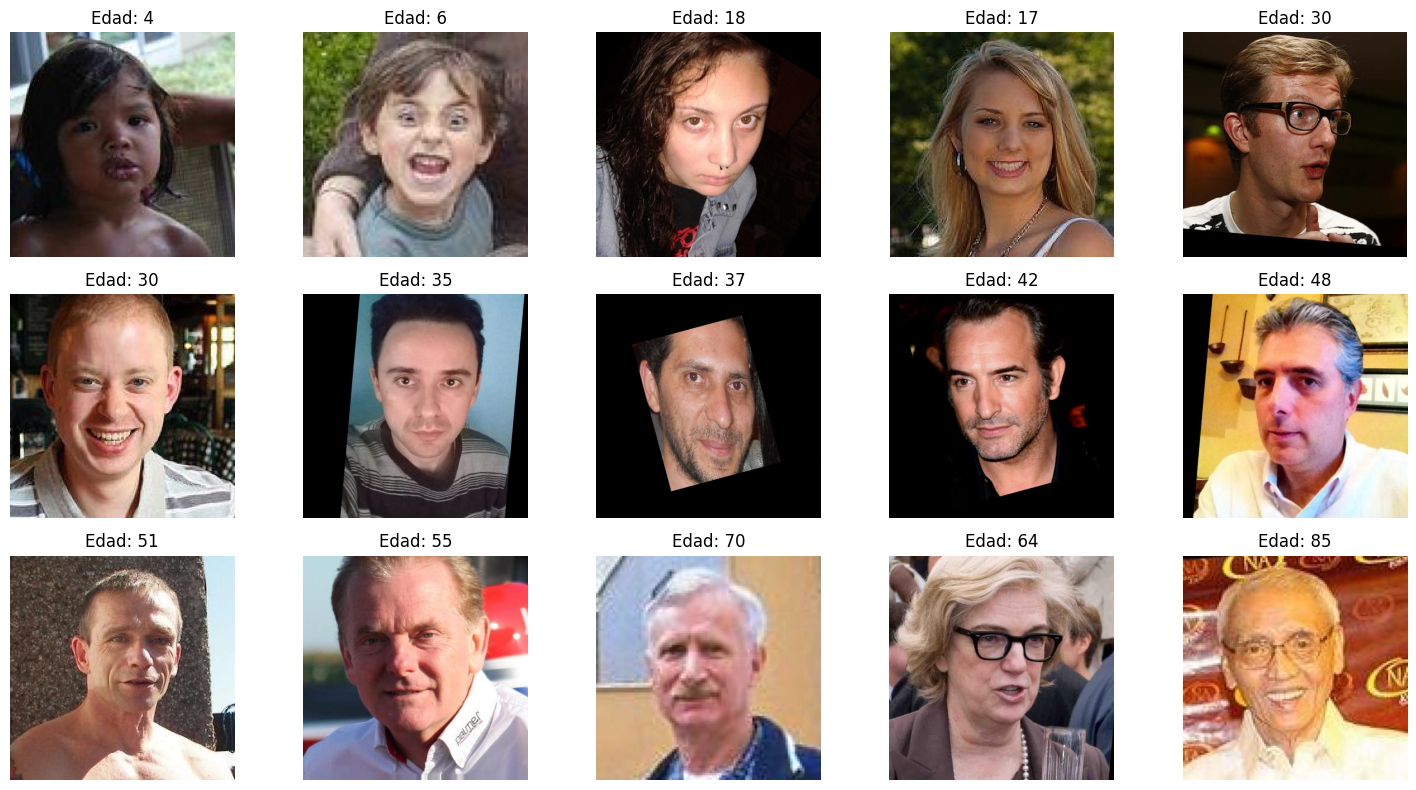

In [5]:
#Muestra de imágenes
# Crear buckets de edad
bins = [0, 10, 20, 30, 40, 50, 60, 80, 100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-80','80-100']
df['age_group'] = pd.cut(df['real_age'], bins=bins, labels=labels)

# Tomar 2 imágenes a la vez
sample_df = df.groupby('age_group').apply(lambda x: x.sample(min(2, len(x)), random_state=42)).reset_index(drop=True)
print(f"Se seleccionaron {len(sample_df)} imágenes para mostrar.")

# Visualizar imágenes
plt.figure(figsize=(15,8))

for i, row in sample_df.iterrows():
    img_path = images_dir + "/" + row['file_name']
    try:
        img = Image.open(img_path)
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f"Edad: {int(row['real_age'])}")
        plt.axis('off')
    except Exception as e:
        print(f"Error abriendo imagen: {img_path} -> {e}")

plt.tight_layout()
plt.show()

### Conclusiones

7591 imágenes de 31 años como edad promedio. 75% de los datos entre los 20 y 41 años.

Naturalmente por la riqueza en datos de mediana edad, el modelo se desempeñará mejor en reconocer jovenes y adultos jóvenes por sobre adultos mayores y niños.

Técnicas de muestreo y escalado podrían ser útiles si se busca mejorar la predicción de los grupos de edad atípica. 

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [6]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    Usa ImageDataGenerator con aumentos.
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        zoom_range=0.1
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_gen

In [8]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return val_gen

In [9]:
def create_model(input_shape):
    """
    Define el modelo con base en ResNet50.
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Congelar pesos base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Salida continua (edad)
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros.
    """
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        verbose=2
    )
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [11]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import scipy
import tensorflow as tf
import sys
sys.modules['scipy'] = scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [12]:
#Código local 
# Paso 1 – Cargar datos de entrenamiento
train_gen = load_train(path)

# Paso 2 – Cargar datos de validación/prueba
val_gen = load_test(path)

# Paso 3 – Crear modelo
model = create_model((224, 224, 3))

# Paso 4 – Entrenar el modelo
model_trained = train_model(
    model,
    train_gen,
    val_gen,
    epochs=10,
    batch_size=32,
    steps_per_epoch=None,
    validation_steps=None
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/10
178/178 - 789s - loss: 641.6276 - mae: 19.6998 - val_loss: 284.2088 - val_mae: 12.8471 - 789s/epoch - 4s/step
Epoch 2/10
178/178 - 607s - loss: 319.5185 - mae: 13.7737 - val_loss: 283.4434 - val_mae: 13.2386 - 607s/epoch - 3s/step
Epoch 3/10
178/178 - 635s - loss: 317.5188 - mae: 13.7172 - val_loss: 284.4455 - val_mae: 13.3163 - 635s/epoch - 4s/step
Epoch 4/10
178/178 - 612s - loss: 312.7845 - mae: 13.7027 - val_loss: 284.8368 - val_mae: 13.3429 - 612s/epoch - 3s/step
Epoch 5/10
178/178 - 611s - loss: 314.4747 - mae: 13.7382 - val_loss: 284.3759 - val_mae: 13.3079 - 611s/epoch - 3s/step
Epoch 6/10
178/178 - 618s - loss: 314.5311 - mae: 13.7143 - val_loss: 283.6167 - val_mae: 13.2461 - 618s/epoch - 3s/step
Epoch 7/10
178/178 - 608s - loss: 307.6983 - mae: 13.5613 - val_loss: 284.6526 - val_mae: 13.3261 - 608s/epoch - 3s/step
Epoch 8/10
178/178 - 628s - loss: 310.9779 - mae: 13.6271 - val_loss: 285.741

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

## Conclusiones

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo